<a href="https://colab.research.google.com/github/Kaiziferr/deep_learning/blob/master/multilayer_perceptron/02_workshop_parameter_optimizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn import metrics

In [2]:
data = pd.read_csv('https://raw.githubusercontent.com/Kaiziferr/Deep_Learning_Workshop/master/workshop_keras_sklearn_introduction/diabetes.csv')
data_values = data.values

In [3]:
def create_base_model():
  model = Sequential()
  model.add(Dense(12, input_dim = 8, activation = 'relu', kernel_initializer='glorot_uniform'))
  model.add(Dense(8, activation = 'relu', kernel_initializer='glorot_uniform'))
  model.add(Dense(1, activation='sigmoid', kernel_initializer='glorot_uniform'))
  model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
  return model

# **Data Split**

---



In [4]:
X = data_values[:,:8]
y = data_values[:,8]

# **Houldot**

---



In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle = True, stratify = y, random_state=1234)

# **Wrapper**

---



In [6]:
model = KerasClassifier(build_fn=create_base_model, epochs = 150, batch_size = 10, verbose = 0)

kfold = StratifiedKFold(n_splits=10, shuffle=True)
result = cross_val_score(model, X, y, cv = kfold)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  """Entry point for launching an IPython kernel.


In [7]:
result

array([0.6883117 , 0.75324672, 0.72727275, 0.72727275, 0.75324672,
       0.66233766, 0.75324672, 0.64935064, 0.7368421 , 0.69736844])

- Los resultados no parecen ser tan alejados los unos de los otros

In [8]:
result.mean() , result.std()

(0.7148496210575104, 0.036431888463049254)

- La media es confiable, ya que la dispersión no es tán prolongada.

# **Optimización de hiperparametros**

---



In [9]:
def create_model_optimizer(optimizer = 'rmsprop', init = 'glorot_uniform'):
  model = Sequential()
  model.add(Dense(12, input_dim = 8, kernel_initializer=init, activation='relu'))
  model.add(Dense(8, kernel_initializer=init, activation='relu'))
  model.add(Dense(1, kernel_initializer=init, activation='relu'))
  model.compile(loss = 'binary_crossentropy', optimizer = optimizer, metrics = ['accuracy'])
  return model

In [10]:
model = KerasClassifier(build_fn=create_model_optimizer, verbose = 0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  """Entry point for launching an IPython kernel.


In [11]:
optimizer = ['rmsprop', 'adam']
init = ['glorot_uniform', 'normal', 'uniform']
epochs = [50 ,100 ,150]
batch = [5, 10, 20]
param_grid = dict(optimizer = optimizer, epochs = epochs, batch_size = batch, init = init)
grid = GridSearchCV(estimator=model, param_grid = param_grid, refit=True, return_train_score=True, cv = 3)

In [12]:
grid.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x7f742ce7f710>,
             param_grid={'batch_size': [5, 10, 20], 'epochs': [50, 100, 150],
                         'init': ['glorot_uniform', 'normal', 'uniform'],
                         'optimizer': ['rmsprop', 'adam']},
             return_train_score=True)

In [13]:
print('Mejor: %f usando %s' % (grid.best_score_, grid.best_params_))

Mejor: 0.746528 usando {'batch_size': 5, 'epochs': 150, 'init': 'normal', 'optimizer': 'rmsprop'}


- Tiene una media en el mejor score con una disperción muy baja

In [14]:
means = grid.cv_results_['mean_test_score']
stds = grid.cv_results_['std_test_score']
params = grid.cv_results_['params']

for mean, std, param in zip(means, stds, params):
  print('%f (%f) con %r' % (mean, std, param))

0.651042 (0.057528) con {'batch_size': 5, 'epochs': 50, 'init': 'glorot_uniform', 'optimizer': 'rmsprop'}
0.598958 (0.127790) con {'batch_size': 5, 'epochs': 50, 'init': 'glorot_uniform', 'optimizer': 'adam'}
0.730903 (0.024918) con {'batch_size': 5, 'epochs': 50, 'init': 'normal', 'optimizer': 'rmsprop'}
0.651042 (0.057528) con {'batch_size': 5, 'epochs': 50, 'init': 'normal', 'optimizer': 'adam'}
0.732639 (0.030170) con {'batch_size': 5, 'epochs': 50, 'init': 'uniform', 'optimizer': 'rmsprop'}
0.663194 (0.072461) con {'batch_size': 5, 'epochs': 50, 'init': 'uniform', 'optimizer': 'adam'}
0.640625 (0.066835) con {'batch_size': 5, 'epochs': 100, 'init': 'glorot_uniform', 'optimizer': 'rmsprop'}
0.647569 (0.070178) con {'batch_size': 5, 'epochs': 100, 'init': 'glorot_uniform', 'optimizer': 'adam'}
0.689236 (0.025633) con {'batch_size': 5, 'epochs': 100, 'init': 'normal', 'optimizer': 'rmsprop'}
0.727431 (0.020097) con {'batch_size': 5, 'epochs': 100, 'init': 'normal', 'optimizer': 'adam

In [15]:
model_final = grid.best_estimator_
model_final.get_params()

{'batch_size': 5,
 'build_fn': <function __main__.create_model_optimizer>,
 'epochs': 150,
 'init': 'normal',
 'optimizer': 'rmsprop',
 'verbose': 0}

# **Prediccion**

---



### **Problema de optimización**

---



In [16]:
y_pred = model_final.predict(X_train)

##### **Metricas**

---



In [17]:
matrix = metrics.confusion_matrix(y_train, y_pred)
matrix

array([[309,  66],
       [ 70, 131]])

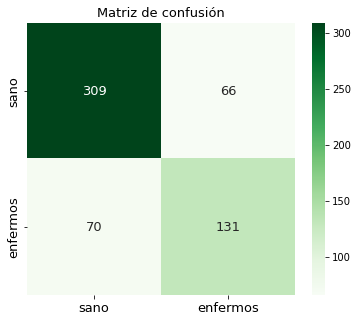

In [18]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize = (6,5))
sns.heatmap(matrix, annot=True, ax=ax, cmap=plt.cm.Greens, fmt = 'g', annot_kws={'size':13})
ax.set_title('Matriz de confusión', size = 13)
ax.xaxis.set_ticklabels(['sano', 'enfermos'])
ax.yaxis.set_ticklabels(['sano', 'enfermos'])
ax.tick_params(labelsize = 13)

In [19]:
print(f'Accuracy    : {metrics.accuracy_score(y_train, y_pred)}')
print(f'Kappa       : {metrics.cohen_kappa_score(y_train, y_pred)}')

print(f'Preddicción enfermos')
print(f'Predicción  : {metrics.precision_score(y_train, y_pred, labels=[1], average="macro")}')
print(f'Recall      : {metrics.recall_score(y_train, y_pred, labels=[1], average="macro")}')

VN = matrix[0,0]
FP = matrix[0,1]
specificity = VN/(VN+FP)

print(f'Specificity : {specificity}')
print(f'F1-score    : {metrics.f1_score(y_train, y_pred, labels=[1], average="macro")}')

Accuracy    : 0.7638888888888888
Kappa       : 0.4779479387420529
Preddicción enfermos
Predicción  : 0.6649746192893401
Recall      : 0.6517412935323383
Specificity : 0.824
F1-score    : 0.6582914572864321


### **Problema de inferencia**

---



In [20]:
y_pred = model_final.predict(X_test)

##### **Metricas**

---



In [21]:
matrix = metrics.confusion_matrix(y_test, y_pred)
matrix

array([[97, 28],
       [22, 45]])

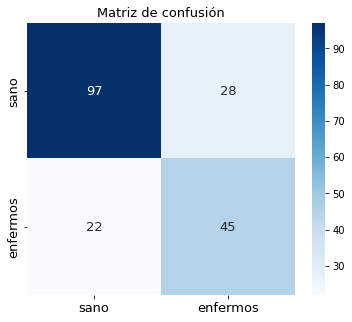

In [22]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize = (6,5))
sns.heatmap(matrix, annot=True, ax=ax, cmap=plt.cm.Blues, fmt = 'g', annot_kws={'size':13})
ax.set_title('Matriz de confusión', size = 13)
ax.xaxis.set_ticklabels(['sano', 'enfermos'])
ax.yaxis.set_ticklabels(['sano', 'enfermos'])
ax.tick_params(labelsize = 13)

In [23]:
print(f'Accuracy    : {metrics.accuracy_score(y_test, y_pred)}')
print(f'Kappa       : {metrics.cohen_kappa_score(y_test, y_pred)}')

print(f'Preddicción enfermos')
print(f'Predicción  : {metrics.precision_score(y_test, y_pred, labels=[1], average="macro")}')
print(f'Recall      : {metrics.recall_score(y_test, y_pred, labels=[1], average="macro")}')

VN = matrix[0,0]
FP = matrix[0,1]
specificity = VN/(VN+FP)

print(f'Specificity : {specificity}')
print(f'F1-score    : {metrics.f1_score(y_test, y_pred, labels=[1], average="macro")}')

Accuracy    : 0.7395833333333334
Kappa       : 0.4385308223183998
Preddicción enfermos
Predicción  : 0.6164383561643836
Recall      : 0.6716417910447762
Specificity : 0.776
F1-score    : 0.6428571428571429


- El modelo aun no es muy bueno para la detección de enferos, la sensibilidad está por debajo del 50%
- La predicción no es buena metrica, ya que los datos están desbalanceados, ademas está aun por debajo de la precisión del conjunto de datos de entrenamiento.

In [30]:
y_prob = model_final.predict_proba(X_test)
pos_prob = y_prob[:, 1]
fpr, tpr, _ = metrics.roc_curve(y_test, pos_prob)
fpr, tpr

(array([0.   , 0.   , 0.   , 0.008, 0.008, 0.016, 0.016, 0.024, 0.024,
        0.032, 0.032, 0.04 , 0.04 , 0.048, 0.048, 0.064, 0.064, 0.072,
        0.072, 0.08 , 0.08 , 0.088, 0.088, 0.104, 0.104, 0.112, 0.112,
        0.12 , 0.12 , 0.136, 0.136, 0.152, 0.152, 0.168, 0.168, 0.184,
        0.184, 0.224, 0.224, 0.24 , 0.24 , 0.312, 0.312, 0.32 , 0.32 ,
        0.336, 0.336, 0.344, 0.344, 0.4  , 0.4  , 0.448, 0.448, 0.504,
        0.504, 0.512, 0.512, 0.56 , 0.56 , 0.592, 0.592, 0.648, 0.648,
        0.704, 0.704, 0.712, 0.712, 0.72 , 0.72 , 0.744, 0.744, 0.792,
        0.792, 0.824, 0.824, 0.84 , 0.84 , 0.872, 1.   ]),
 array([0.        , 0.01492537, 0.07462687, 0.07462687, 0.2238806 ,
        0.2238806 , 0.28358209, 0.28358209, 0.31343284, 0.31343284,
        0.34328358, 0.34328358, 0.35820896, 0.35820896, 0.37313433,
        0.37313433, 0.3880597 , 0.3880597 , 0.40298507, 0.40298507,
        0.41791045, 0.41791045, 0.43283582, 0.43283582, 0.47761194,
        0.47761194, 0.50746269, 0

# **ROC**
---



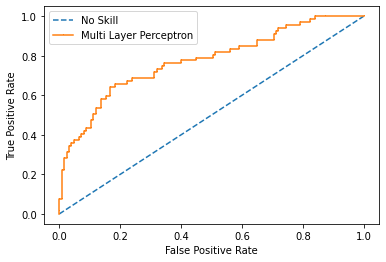

In [32]:
plt.plot([0, 1], [0, 1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker=',', label = 'Multi Layer Perceptron')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

# **AUC Score**
---



In [34]:
roc_auc = metrics.roc_auc_score(y_test, pos_prob)
print('Multi Layer Perceptron AUC %.3f' % roc_auc)

Multi Layer Perceptron 0.774


- El area de bajo de la curva muestra que el modelo tiene un rendimiento aceptable en la predicción de ambas clases, aunque se resalta que el conjunto de datos es desbalanceado.

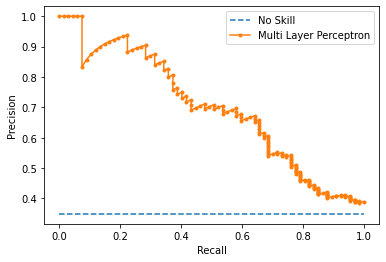

In [38]:
no_skill = len(y[y==1]) / len(y)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
precision, recall, _ = metrics.precision_recall_curve(y_test, pos_prob)
plt.plot(recall, presicion, marker='.', label='Multi Layer Perceptron')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

In [39]:
auc_score = metrics.auc(recall, precision)
print('Multi Layer Perceptron PR AUC: %.3f' % auc_score)

Multi Layer Perceptron PR AUC: 0.697


- El modelo tiene un rendimiento inferior en la predicción de los enfermos (70%) con la curva de precision-recall que con el rendimiento que la curva ROC